<a href="https://colab.research.google.com/github/talhaanwarch/IDDs_EEG_ML_classification/blob/master/MNE_features_Rest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.biorxiv.org/content/10.1101/759738v1.full.pdf  
https://www.sciencedirect.com/science/article/pii/S2352340920303826  
https://data.mendeley.com/datasets/fshy54ypyh/1  

In [ ]:
# %%capture
# !pip install git+https://github.com/raphaelvallat/entropy.git

In [1]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip

--2020-06-17 03:21:06--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.24.232
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.24.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34220065 (33M) [application/octet-stream]
Saving to: ‘fshy54ypyh-1.zip’

fshy54ypyh-1.zip    100%[===================>]  32.63M  18.4MB/s    in 1.8s    

2020-06-17 03:21:08 (18.4 MB/s) - ‘fshy54ypyh-1.zip’ saved [34220065/34220065]



In [2]:
%%capture
!pip install git+https://github.com/mne-tools/mne-features.git#egg=mne_features

In [3]:
%%capture 
!unzip fshy54ypyh-1.zip

In [4]:
import scipy.io
from glob import glob
import numpy as np
from tqdm import tqdm
from mne_features.feature_extraction import FeatureExtractor
from mne_features.univariate   import compute_pow_freq_bands

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
IDD='/content/Data/Data/CleanData/Data/Data/CleanData/CleanData_IDD'
TDC='/content/Data/CleanData/CleanData_TDC'

In [6]:
!rm '/content/Data/Data/CleanData/Data/Data/CleanData/CleanData_IDD/Rest/NDS001_Rest_CD(1).mat'

In [7]:
IDD_rest=[]
for i in glob(IDD+'/Rest/*.mat'):
    data=scipy.io.loadmat(i)['clean_data'].reshape(14,-1,128*4)
    data=np.swapaxes(data,0,1)
    IDD_rest.append(data )

TDC_rest=[]
for i in glob(TDC+'/Rest/*.mat'):
    data=scipy.io.loadmat(i)['clean_data'].reshape(14,-1,128*4)
    data=np.swapaxes(data,0,1)
    TDC_rest.append(data )

In [8]:
len(IDD_rest),len(TDC_rest)

(7, 7)

In [9]:
print(IDD_rest[0].shape)

(30, 14, 512)


In [10]:
#for mne package shape shhould be trial,channel,length

In [11]:

def pow_freq(x):
  return compute_pow_freq_bands(128,x,freq_bands=np.array([0.5, 4., 8., 13.,30.]))

In [12]:
feature=[('powfreq', pow_freq),'app_entropy', 'decorr_time', 'higuchi_fd', 'hjorth_complexity', 'hjorth_complexity_spect', 'hjorth_mobility', 'hjorth_mobility_spect', 'hurst_exp', 'katz_fd', 'kurtosis', 'line_length', 'mean', 'ptp_amp', 'samp_entropy', 'skewness', 'spect_entropy', 'spect_slope', 'std', 'svd_entropy', 'svd_fisher_info', 'teager_kaiser_energy', 'variance', 'wavelet_coef_energy', 'zero_crossings', 'max_cross_corr', 'nonlin_interdep', 'phase_lock_val', 'spect_corr', 'time_corr']
fe = FeatureExtractor(sfreq=128, selected_funcs=feature)

In [13]:
import warnings
warnings.filterwarnings("ignore")
feature1=[]
feature2=[]
for i in tqdm(range(7)):
  feature1.append(fe.fit_transform(IDD_rest[i]))
  feature2.append(fe.fit_transform(TDC_rest[i]))

100%|██████████| 7/7 [17:16<00:00, 148.09s/it]


In [14]:
feature1[0].shape

(30, 1169)

In [15]:
x1=np.array(feature1)        
x2=np.array(feature2) 
print(x1.shape,x2.shape)

(7, 30, 1169) (7, 30, 1169)


In [65]:
X=np.concatenate((x1,x2),axis=0)

y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))
X.shape,y.shape

((14, 30, 1169), (14,))

In [67]:
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,LeaveOneOut,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

score=[]
for train,test in StratifiedKFold(7).split(X,y):
  X_train=X[train].reshape(-1,X.shape[2])
  X_test=X[test].reshape(-1,X.shape[2])
  y_train=np.concatenate([[i]*X.shape[1] for i in y[train]])
  y_test=np.concatenate([[i]*X.shape[1] for i in y[test]])
  sc=StandardScaler()
  X_train=sc.fit_transform(X_train)
  X_test=sc.transform(X_test)

  clf=SVC(kernel='rbf')
  clf.fit(X_train,y_train)
  print(clf.score(X_test,y_test))
  score.append(clf.score(X_test,y_test))

0.9333333333333333
0.9833333333333333
0.5333333333333333
1.0
0.9666666666666667
0.9833333333333333
1.0


In [68]:
np.mean(score)

0.9142857142857143

In [69]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [70]:
accuracy_avg=[]
accuracy_std=[]
f1_avg=[]
f1_std=[]
for clfs in classifiers:
    # print('====================================')
    # name = clfs.__class__.__name__
    # print(name)
    acc_scores=[]
    f1_scores=[]
    for train,test in StratifiedKFold(7).split(X,y):
      X_train=X[train].reshape(-1,X.shape[2])
      X_test=X[test].reshape(-1,X.shape[2])
      y_train=np.concatenate([[i]*X.shape[1] for i in y[train]])
      y_test=np.concatenate([[i]*X.shape[1] for i in y[test]])
      sc=StandardScaler()
      X_train=sc.fit_transform(X_train)
      X_test=sc.transform(X_test)
      X_train, y_train = shuffle(X_train, y_train)

      clfs.fit(X_train,y_train)
      y_pred=clfs.predict(X_test)
      acc_scores.append(accuracy_score(y_test,y_pred))
      f1_scores.append(f1_score(y_test,y_pred))
    accuracy_avg.append(np.mean(acc_scores))
    accuracy_std.append(np.std(acc_scores))
    f1_avg.append(np.mean(f1_scores))
    f1_std.append(np.std(f1_scores))

Text(0.5, 1.0, 'Classifiers')

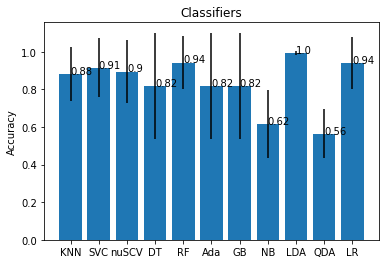

In [71]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(accuracy_avg),yerr=np.array(accuracy_std))
ys=np.array(accuracy_avg)
for index, value in enumerate(ys):
    plt.text(index,value, str(np.round(value,2)))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')

Text(0.5, 1.0, 'Classifiers')

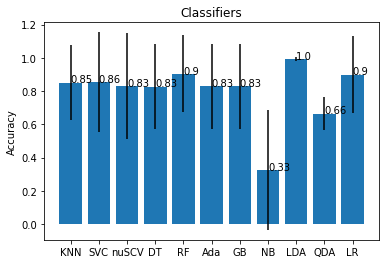

In [72]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(f1_avg),yerr=np.array(f1_std))
ys=np.array(f1_avg)
for index, value in enumerate(ys):
    plt.text(index,value, str(np.round(value,2)))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')